## Instance Segmentation Using Habitat-Sim and Mask-R-CNN

author: Michael Piseno (mpiseno@fb.com)

This notebook will demonstrate how to set up an efficient datapipline for the purpose of instance segmentation using PyTorch, Mask-R-CNN, and Habitat-Sim as a data generator.

Other resources:
* [Mask-R-CNN paper](https://arxiv.org/pdf/1703.06870.pdf)
* [PyTorch instance segmentation tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [1]:
import os
import time
import math
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset

from habitat_sim.utils.data.dataextractor import ImageExtractor

### Data preparation and proprocessing

Below we will define the data extraction and preprocessing steps. Habitat-Sim's image data extraction API will be used to gather images from within the simulator for use inside a PyTorch Dataset subclass, which is subsequently fed into a PyTorch dataloader.

In [2]:
def collate_fn(batch):
    return tuple(zip(*batch))
    
    
class HabitatDataset(Dataset):
    def __init__(self, extractor, transform=None):
        self.extractor = extractor
        self.transform = transform
        self.label_map = extractor.label_map
        
        # Create a mapping from class name to class ID
        classes = np.unique([val for val in self.label_map.values()])
        self.class_name_to_id = {
            name: id_val for id_val, name in enumerate(classes)
        }
        
    def __len__(self):
        return len(self.extractor)
    
    def __getitem__(self, idx):
        sample = self.extractor[idx]
        img, mask = sample["rgb"][:, :, :3], sample["semantic"]
        H, W = mask.shape
        
        obj_ids = np.unique(mask)
        masks = np.array([mask == obj_id for obj_id in obj_ids])
        label_names = [self.label_map[obj_id] for obj_id in obj_ids]
        labels = [self.class_name_to_id[name] for name in label_names]
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            
            # Avoid zero area boxes
            if xmin == xmax:
                xmin = max(0, xmin - 1)
                xmax = min(W, xmax + 1)
            if ymin == ymax:
                ymin = max(0, ymin - 1)
                ymax = min(H, ymax + 1)
            
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transform:
            img = self.transform(img)
        
        return img, target
    

try:
    extractor.close()
except:
    pass

 
scene = "/private/home/mpiseno/Documents/Habitat/data/scene1/17DRP5sb8fy.glb" # mp3d
#scene = "/private/home/mpiseno/Documents/Habitat/sorted_faces/18_scenes/apartment_1/mesh.ply" # Replica
#scene_dir = "/private/home/mpiseno/Documents/Habitat/data/" # Replace with your scene directory
extractor = ImageExtractor(scene, output=["rgb", "depth", "semantic"], shuffle=False)


I0212 17:41:52.843181 54709 simulator.py:131] Loaded navmesh /private/home/mpiseno/Documents/Habitat/data/scene1/17DRP5sb8fy.navmesh


sim_cfg.physics_config_file = ./data/default.phys_scene_config.json
sim_cfg.physics_config_file = ./data/default.phys_scene_config.json


First we instantiate an ImageExtractor from Habitat-Sim. This requires that we previde either a the filepath to a scene or a filepath to a diretory which contains several scene files. The navmesh files much be in the same directory as their respective .glb file. Optionally, we can specify the type of output we would like from the extractor. The default is just RGB images.

Example
```python
scene_filepath = "./data/scene1/skokloster-castle.glb"
extractor = ImageExtractor(scene_filepath, output=["rgb", "semantic"])
```

We then create a custom class that subclasses PyTorch's dataset and override the __len__ and __getitem__ methods. Mask-R-CNN requires that we provide the image, bounding boxes, semantic masks, and class labels for each example, so we have implemented functionality for that in the __getitem__ method.

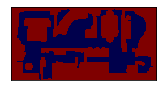

In [3]:
extractor.pose_extractor._show_topdown_view(show_valid_points=False)

In [4]:
from PIL import Image
from habitat_sim.utils.common import d3_40_colors_rgb

def display_sample(rgb_obs, semantic_obs, depth_obs):
    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")

    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_obs, depth_img]
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

In [ ]:
total_frames = 0
# action_names = list(
#     extractor.sim.agents[
#         sim_settings["default_agent"]
#     ].action_space.keys()
# )

max_frames = 5

while total_frames < max_frames:
    #action = random.choice(action_names)
    action = 'turn_left'
    print("action", action)
    observations = extractor.sim.step(action)
    rgb = observations["color_sensor"]
    semantic = observations["semantic_sensor"]
    depth = observations["depth_sensor"]

    display_sample(rgb, semantic, depth)

    total_frames += 1

In [ ]:
for sample in extractor:
    rgb = sample["rgb"]
    semantic = sample["semantic"]
    depth = sample["depth"]
    
    display_sample(rgb, semantic, depth)

In [5]:
# Specify which transforms to apply to the data in preprocessing
transform = T.Compose([
    T.ToTensor()
])

dataset_train = HabitatDataset(extractor, transform=transform)
dataset_test = HabitatDataset(extractor, transform=transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=False,
                                          collate_fn=collate_fn)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=False,
                                          collate_fn=collate_fn)

In [ ]:
import matplotlib.patches as patches


def show_data(data_idx, mask_idx=0, show_masks=False):
    img, target = dataset_train[data_idx]
    idx = mask_idx

    print(f'Num masks: {len(target["masks"])}')
    img = img.permute(1, 2, 0).numpy()
    masks = target['masks'].numpy()
    boxes = target['boxes'].numpy()
    labels = target['labels']
    areas = target['area']
    fig ,ax = plt.subplots(1)
    ax.imshow(img)
    cmap = {0: 'r', 1: 'g', 2: 'b', 3: 'c', 4: 'm', 5: 'y', 6: 'k', 7: 'w'}
    for i, box in enumerate(boxes):
        h, w = box[3] - box[1], box[2] - box[0]
        rect = patches.Rectangle((box[0], box[1]) , w, h, linewidth=2,
                                 edgecolor=cmap[i % len(cmap)], facecolor='none')
        ax.add_patch(rect)

    if show_masks:
        plt.show()
        fig=plt.figure(figsize=(8, 8))
        columns = 4
        rows = math.ceil(len(target['masks']) / columns)
        for i in range(1, columns * rows + 1):
            if i > len(target['masks']):
                break
            mask = masks[i - 1]
            fig.add_subplot(rows, columns, i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mask)
        
show_data(1, show_masks=True)

In [ ]:
show_data(9, show_masks=True)

### Model and Training Setup

In [6]:
# Credit: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


num_epochs = 100
num_classes = len(dataset_train.class_name_to_id) # Number of unique class names
model_weights_path = "examples/instance_segmentation/saved_runs/maskrcnn-example-weights.pt"
load_weights = False

model = build_model(num_classes)
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


### Training and Evaluation

In [7]:
from examples.instance_segmentation.engine import train_one_epoch

# ==== Training ====

epoch = 0
if load_weights:
    # Load model
    print('Loading model!')
    checkpoint = torch.load(model_weights_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.train()

# We have to explicitly set the extractor mode because there can only be one instance of an extractor at a time,
# so the dataset_train and dataset_test must share the same extractor
extractor.set_mode('train')

while epoch < num_epochs:
    train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=10)
    lr_scheduler.step()
    
    if epoch % 100 == 0:
        # Save model
        print('Saving model!')
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, model_weights_path)
    
    epoch += 1

# import math

# for i, batch in enumerate(data_loader):
#     images, targets = batch
#     images = list(image.to(device) for image in images)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
#     loss_dict = model(images, targets)
#     losses = sum(loss for loss in loss_dict.values())
#     print(loss_dict)
#     print(str(losses.item()) + "\n")
    
#     if not math.isfinite(losses):
#         print(f'not finite loss: {i}')
#         break

Epoch: [0]  [0/8]  eta: 0:01:59  lr: 0.000719  loss: 10.0960 (10.0960)  loss_classifier: 3.4656 (3.4656)  loss_box_reg: 0.5355 (0.5355)  loss_mask: 1.3897 (1.3897)  loss_objectness: 3.0516 (3.0516)  loss_rpn_box_reg: 1.6535 (1.6535)  time: 14.9352  data: 0.0536  max mem: 0


KeyboardInterrupt: 

In [8]:
# ==== Testing ====
from examples.instance_segmentation.engine import evaluate

extractor.set_mode('test')

evaluate(model, dataloader_test, device=device)



creating index...
index created!
Test:  [0/4]  eta: 0:01:14  model_time: 16.4295 (16.4295)  evaluator_time: 0.2311 (0.2311)  time: 18.6904  data: 0.0985  max mem: 0
Test:  [3/4]  eta: 0:00:14  model_time: 15.3305 (13.6976)  evaluator_time: 0.2219 (0.1996)  time: 14.4680  data: 0.0803  max mem: 0
Test: Total time: 0:00:57 (14.4684 s / it)
Averaged stats: model_time: 15.3305 (13.6976)  evaluator_time: 0.2219 (0.1996)
Accumulating evaluation results...
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxD

In [ ]:
out = outputs[0]

masks = out['masks']
mask = masks[8][0].detach().numpy()

mask = mask >= 0.1
print(mask.shape)
plt.imshow(mask)
plt.show()